In [1]:
import h5py
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
pions1 = h5py.File('/fast_scratch/QVAE/data/atlas/pions1.hdf5','r')
photons1 = h5py.File('/fast_scratch/QVAE/data/atlas/photons1.hdf5','r')
photons2 = h5py.File('/fast_scratch/QVAE/data/atlas/photons2.hdf5','r')

In [3]:
pions1_voxels = torch.tensor(pions1["voxels"][:])
pi_true_energy = torch.tensor(pions1["energy"][:])
energy_list = torch.unique(pi_true_energy)

In [57]:
pion_layers = np.array([0, 8, 108, 208, 213, 363, 523, 533])
photon_layers = torch.tensor([0, 8, 168, 358, 363, 368])
pion_lower_lim = pion_layers[0:-1]
pion_upper_lim = pion_layers[1:]
photon_upper_lim = photon_layers[1:]
photon_lower_lim = photon_layers[0:-1]

def Get_Sparsity(dataset, lower_lim, upper_lim, layers):

    #layers_sparsities = np.zeros((pions1_voxels.shape[0], len(pion_layers)-1), dtype=np.float32)
    layer_datasets = [dataset[0][start_idx:end_idx] for start_idx, end_idx in zip(lower_lim, upper_lim)]
    layer_sp = [abs(np.count_nonzero(layer_dataset)/layer_dataset.shape[0]-1) for layer_dataset in layer_datasets]
    data_sparsities = torch.tensor(layer_sp)

    for i in range(1, dataset.shape[0]): #looping over all events
        layer_datasets = [dataset[i][start_idx:end_idx] for start_idx, end_idx in zip(pion_lower_lim, pion_upper_lim)]
        layer_sp = [abs(np.count_nonzero(layer_dataset)/layer_dataset.shape[0]-1) for layer_dataset in layer_datasets]
        data_sparsities = torch.cat((data_sparsities, torch.tensor(layer_sp)), dim=0)

    data_sparsities = data_sparsities.reshape(pions1_voxels.shape[0], len(layers)-1)
    return data_sparsities

In [5]:
unique_energies = np.array([2.5600e+02, 5.1200e+02, 1.0240e+03, 2.0480e+03, 4.0960e+03, 8.1920e+03,
        1.6384e+04, 3.2768e+04, 6.5536e+04, 1.3107e+05, 2.6214e+05, 5.2429e+05,
        1.0486e+06, 2.0972e+06, 4.1943e+06])
def Get_Unique_Energy_Events(pions1_voxels, unique_energy):
    unique_energy_tensor = torch.tensor([])
    dataset = pions1_voxels
    for i in range(pi_true_energy.shape[0]):
        if pi_true_energy[i] == unique_energy:
            unique_energy_tensor = torch.cat((unique_energy_tensor, dataset[i,:].unsqueeze(0)), dim=0)
    print(unique_energy_tensor.shape, unique_energy)
    return unique_energy_tensor

In [6]:
Unique_Energies_data = [Get_Unique_Energy_Events(pions1_voxels, x) for x in energy_list]

torch.Size([10000, 533]) tensor(256., dtype=torch.float64)
torch.Size([10000, 533]) tensor(512., dtype=torch.float64)
torch.Size([10000, 533]) tensor(1024., dtype=torch.float64)
torch.Size([10000, 533]) tensor(2048., dtype=torch.float64)
torch.Size([10000, 533]) tensor(4096., dtype=torch.float64)
torch.Size([10000, 533]) tensor(8192., dtype=torch.float64)
torch.Size([10000, 533]) tensor(16384., dtype=torch.float64)
torch.Size([10000, 533]) tensor(32768., dtype=torch.float64)
torch.Size([10000, 533]) tensor(65536., dtype=torch.float64)
torch.Size([10000, 533]) tensor(131072., dtype=torch.float64)
torch.Size([10000, 533]) tensor(262144., dtype=torch.float64)
torch.Size([5000, 533]) tensor(524288., dtype=torch.float64)
torch.Size([3000, 533]) tensor(1048576., dtype=torch.float64)
torch.Size([2000, 533]) tensor(2097152., dtype=torch.float64)
torch.Size([230, 533]) tensor(4194304., dtype=torch.float64)


In [58]:
#Unique_sparsities = [Get_Sparsity(x, pion_lower_lim, pion_upper_lim, pion_layers) for x in Unique_Energies_data]
All_Sparsities = Get_Sparsity(pions1_voxels, pion_lower_lim, pion_upper_lim, pion_layers)
print(All_Sparsities.shape)

torch.Size([120230, 7])


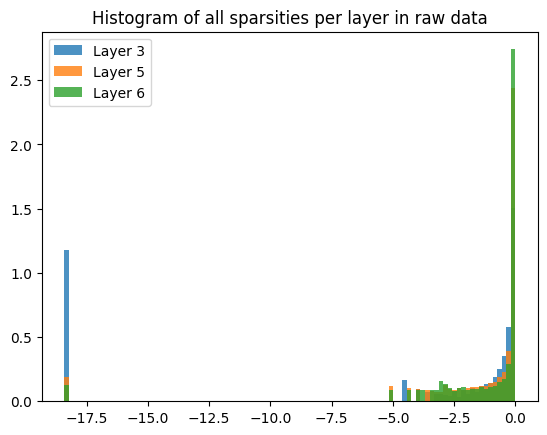

In [59]:
for layer_n in [3, 5, 6]:
    weights = np.ones_like(All_Sparsities[:,layer_n-1])/(float(All_Sparsities.shape[0]*7))
    plt.hist(torch.log(All_Sparsities[:,layer_n-1]+1e-8), density=True, bins=100, alpha=0.8, label = f'Layer {layer_n}')
plt.title('Histogram of all sparsities per layer in raw data')
plt.legend()
plt.show()

Now for sparsities of the scaled data

In [63]:
hdfs = [pions1, photons1]
nplcats = []
nplcats_energies = []

for hdf in hdfs:
    npl0 = np.array(hdf['voxels'])
    npl1 = np.array(hdf['energy'])
    
    npl0 = npl0.reshape(npl0.shape[0], -1)
    npl1 = npl1.reshape(npl1.shape[0], -1)
    
    nplcats.append(np.concatenate([npl0], axis=1))
    nplcats_energies.append(np.concatenate([npl1], axis=1))
    
nplcatscaled = []
transformers = []
arrmins = [[], [], []]
epsilon = 1e-2
count = 0
j_list = []
for i in range(len(nplcats)):
    nparr = nplcats[i]
    nparr = np.where(nparr > 0., nparr, np.nan)  #turn numbers =< 0 into NaN
    transformer = StandardScaler().fit(nparr)
    nparr = transformer.transform(nparr)
    transformers.append(transformer)
    
    nparr = np.where(np.isnan(nparr), np.inf, nparr)  #turn NaN values into +inf
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])   #find minimum per voxel
        
        if arrmin < 0 and not np.isnan(arrmin):
            nparr[:, j] -= arrmin        # removing negative values by shifting all values up
            nparr[:, j] += epsilon       # adding epsilon
            arrmins[i].append(arrmin)
            count += 1
            j_list.append(j)
        else:
            arrmins[i].append(0.)
            
    nparr = np.where(np.isinf(nparr), 0., nparr)   #changing +inf values back to 0
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        if arrmin < 0:
            print(j, arrmin)
            
    nplcatscaled.append(nparr)
#print(j_list, len(j_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [61]:
All_scaled_Sparsities = Get_Sparsity(nplcatscaled[0], pion_lower_lim, pion_upper_lim, pion_layers)
print(All_scaled_Sparsities.shape)

torch.Size([120230, 7])


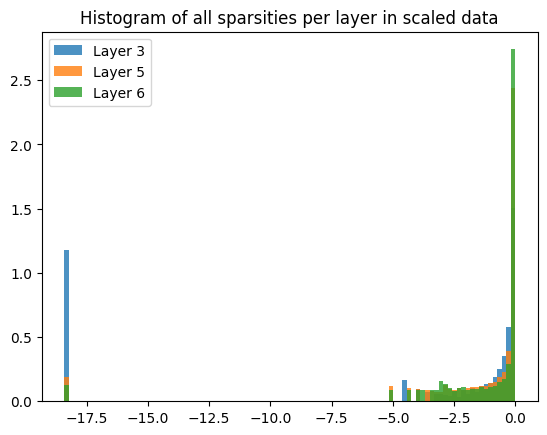

In [62]:
#for layer_n in range(1, All_scaled_Sparsities.shape[1]):
for layer_n in [3, 5, 6]:
    weights = np.ones_like(All_scaled_Sparsities[:,layer_n-1])/(float(All_scaled_Sparsities.shape[0]*7))
    plt.hist(torch.log(All_scaled_Sparsities[:,layer_n-1]+1e-8), density=True, bins=100, alpha=0.8, label = f'Layer {layer_n}')
plt.title('Histogram of all sparsities per layer in scaled data')
plt.legend()
plt.show()

In [71]:
for i in range(All_scaled_Sparsities.shape[0]):
    check = All_scaled_Sparsities[i]-All_Sparsities[i]
    if torch.sum(check, dim=0)>1e-6:
        print(i)

#print(All_Sparsities[2])
#print(pions1_voxels[0])
#print(nplcatscaled[0][0])

In [77]:
for i in range(pions1_voxels.shape[0]):
    if np.count_nonzero(nplcatscaled[0][i]) - np.count_nonzero(pions1_voxels[i]) != 0:
        print("Case")